Project Logo classification

For this assignment, we were provided with a given dataset, that consists of three files:


    - The first file contained image filenames along with their corresponding classes (testing file). 
    - The second file provided bounding box coordinates for each image in the format: filename, class, instance_id, xmin, ymin, xmax, ymax. (training file)
    - The third file had the URLs of images along with their corresponding classes.  
    - Lastly, the images included in the files were provided in a separate folder.

We used the sample code to load the data and utilised TensorFlow and Keras to build a classifier for the logo recognition problem. 

Considering the complexity of image data, we focused on Convolutional Neural Networks (CNNs) as they are well-suited for image classification tasks. Data augmentation techniques were also applied to enhance the model's robustness and generalisation ability.


In [842]:
import os
import numpy as np
import pandas as pd
from PIL import ImageOps
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss
from tensorflow.keras.preprocessing import image_dataset_from_directory
#from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.preprocessing.image import DirectoryIterator, ImageDataGenerator
from tensorflow.keras.applications import Xception #adjusted this to seek the xception from keras and not python, as through python it could not be found
import tensorflow as tf
from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Dense, Activation
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.python.keras.layers import Dense, Activation
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.callbacks import TensorBoard


Our first step was to read our own training and testing set. Using the sample code given to us, the data were loaded from the available files and saved into a format suitable for training, testing and validation (Pandas DataFrame), finally plotting the training and testing images with their respective labels.

### Data Preparation ###

In [843]:
train_img_labels_file = os.path.join(os.getcwd(),
                                    "flickr_logos_27_dataset_training_set_annotation.txt")

train_images = pd.read_csv(train_img_labels_file,
                           sep=' ', 
                           usecols = [i for i in range(7)],
                           header=None,  
                           names=["file_name",'label','subset','x1','y1','x2','y2'])
train_images.head()

,file_name,label,subset,x1,y1,x2,y2
0,144503924.jpg,Adidas,1,38,12,234,142
1,2451569770.jpg,Adidas,1,242,208,413,331
2,390321909.jpg,Adidas,1,13,5,89,60
3,4761260517.jpg,Adidas,1,43,122,358,354
4,4763210295.jpg,Adidas,1,83,63,130,93


In [844]:
test_img_label_file = os.path.join(os.getcwd(),
                                    "flickr_logos_27_dataset_query_set_annotation.txt")

test_images = pd.read_csv(test_img_label_file,
                           sep='\t', 
                            usecols = [i for i in range(2)],
                           header=None,  
                           names=["file_name",'label'])
test_images.head()

,file_name,label
0,2403695909.jpg,Adidas
1,2912587920.jpg,Adidas
2,3441398196.jpg,Adidas
3,4605630935.jpg,Adidas
4,4606245138.jpg,Adidas


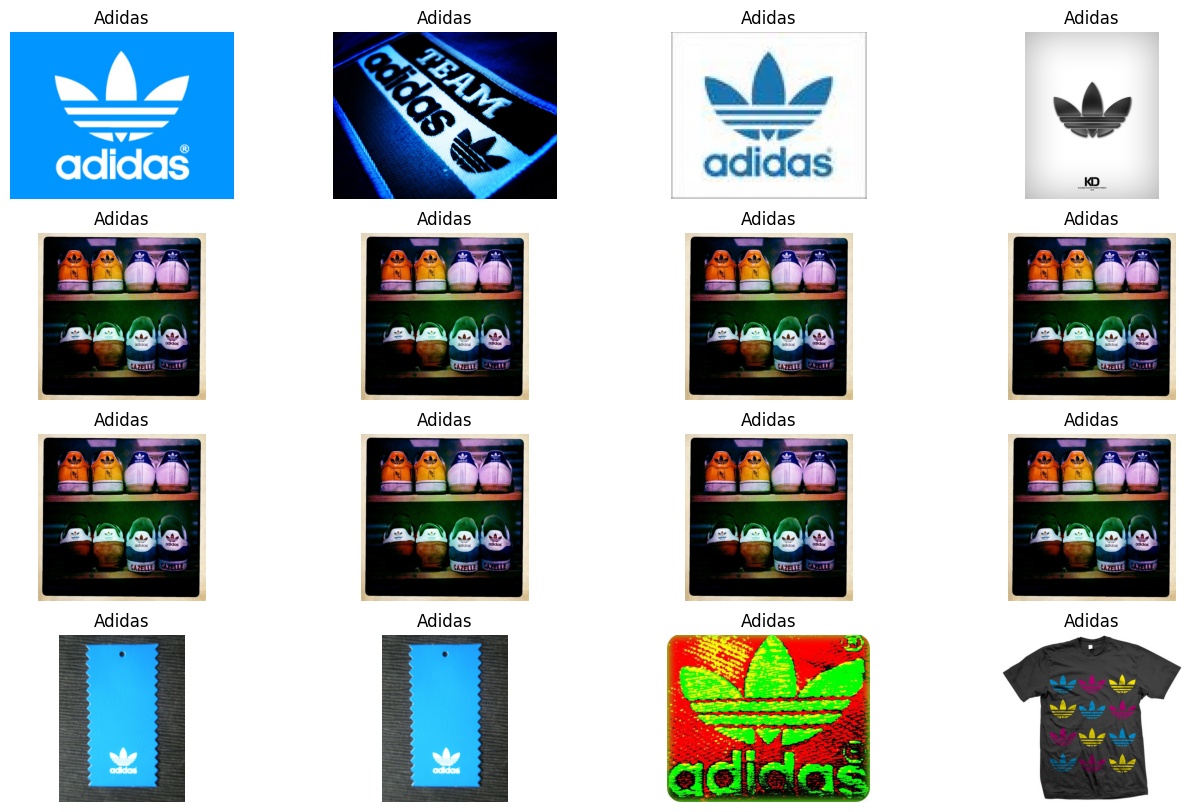

In [845]:
# Training images 

plt.figure(figsize=(16, 10))
for idx in range(16):
    ax = plt.subplot(4, 4, idx + 1)
    plt.imshow(Image.open('flickr_logos_27_dataset_images/'+ train_images.loc[idx,'file_name']))
    plt.title(train_images.loc[idx,'label'])
    plt.axis("off")

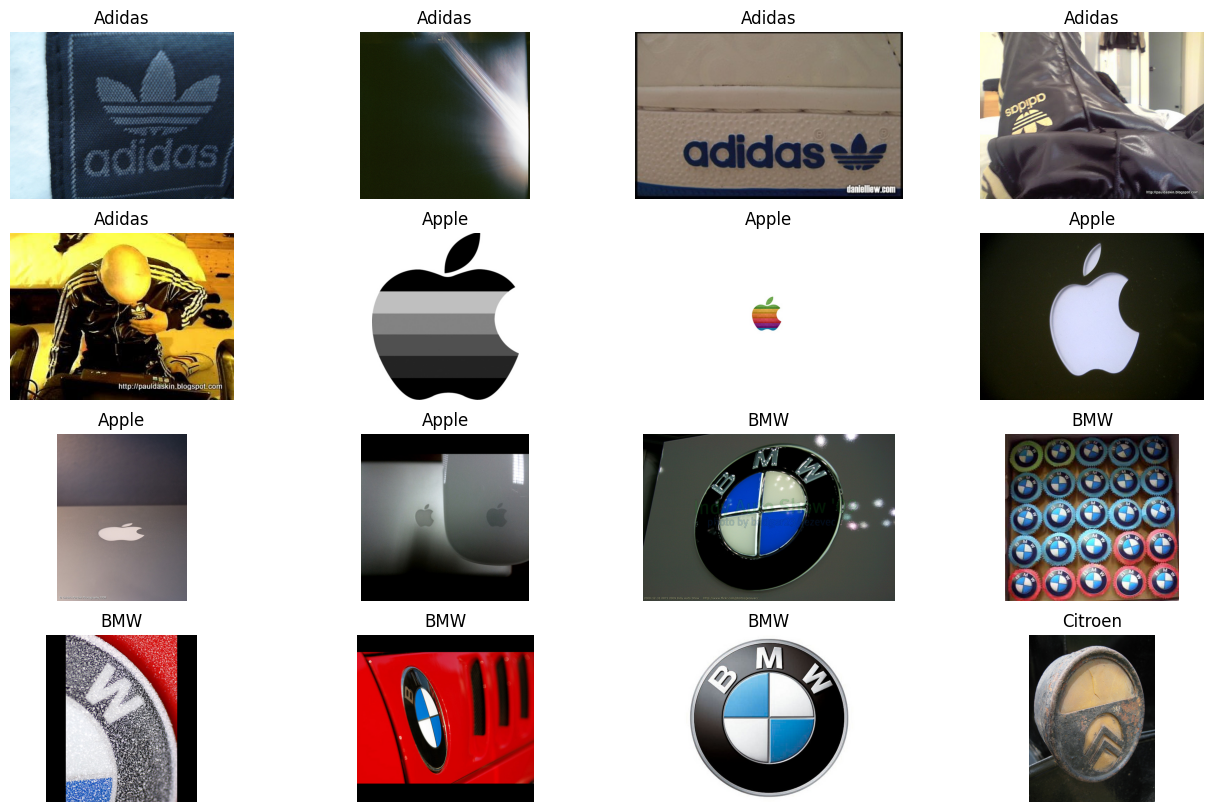

In [847]:
# Same for test images

plt.figure(figsize=(16, 10))
for idx in range(16):
    ax = plt.subplot(4, 4, idx + 1)
    plt.imshow(Image.open('flickr_logos_27_dataset_images/'+ test_images.loc[idx,'file_name']))
    plt.title(test_images.loc[idx,'label'])
    plt.axis("off")

plt.show()

Up until here, the code was practically provided to us ready. The few adjustments made were of the folder paths and the names. 

_From this point on the code was written based on the basic knowledge aquired and also using a few tips and answers on **stackoverflow**_.

### Data Preprocessing ###

We proceeded with the Data Preprocessing steps, cropping the recognised logos in the images, and applied data augmentation to have more equal, easier to compare and use data/items.

    A small note, there is also the option to print the images with no recognised logos, to have a more complete image.

In [850]:
# crop the images as per the annotations file and save a new set of training image instances to a sub-folder

def crop_images(df, source_folder, target_folder):
    os.makedirs(target_folder, exist_ok=True)
     
    for idx, row in df.iterrows():
        image_path = os.path.join(source_folder, row['file_name'])
        img = Image.open(image_path)
        cropped_img = img.crop((row['x1'], row['y1'], row['x2'], row['y2']))
       
       # Print the images that contain no recognised logo, and therefore it cannot be cropped as all the image will get cropped
        if cropped_img.size[0] == 0 or cropped_img.size[1] == 0:
            print(f"No recognised logo could be found: {row['file_name']}")
            continue
        
        cropped_img.save(os.path.join(target_folder, f"{row['file_name']}"))
               
crop_images(train_images, 'flickr_logos_27_dataset_images', 'cropped_images')


No recognised logo could be found: 2662264721.jpg
No recognised logo could be found: 2662264721.jpg
No recognised logo could be found: 2662264721.jpg
No recognised logo could be found: 2662264721.jpg
No recognised logo could be found: 2662264721.jpg


Same for the test images, we cropped and processed them, without cropping them though as we do not have their actual size.

In [851]:
# crop the images as per the query file and save a new set of testing image instances to a sub-folder

def crop_test_images(df, source_folder, target_folder):
    os.makedirs(target_folder, exist_ok=True)
    for idx, row in df.iterrows():
        image_path = os.path.join(source_folder, row['file_name'])
        img = Image.open(image_path)
        
        # For images without bounding box annotations, simply save the image
        img.save(os.path.join(target_folder, f"{row['file_name']}"))

# Crop the test images from the query set
crop_test_images(test_images, 'flickr_logos_27_dataset_images', 'cropped_images')

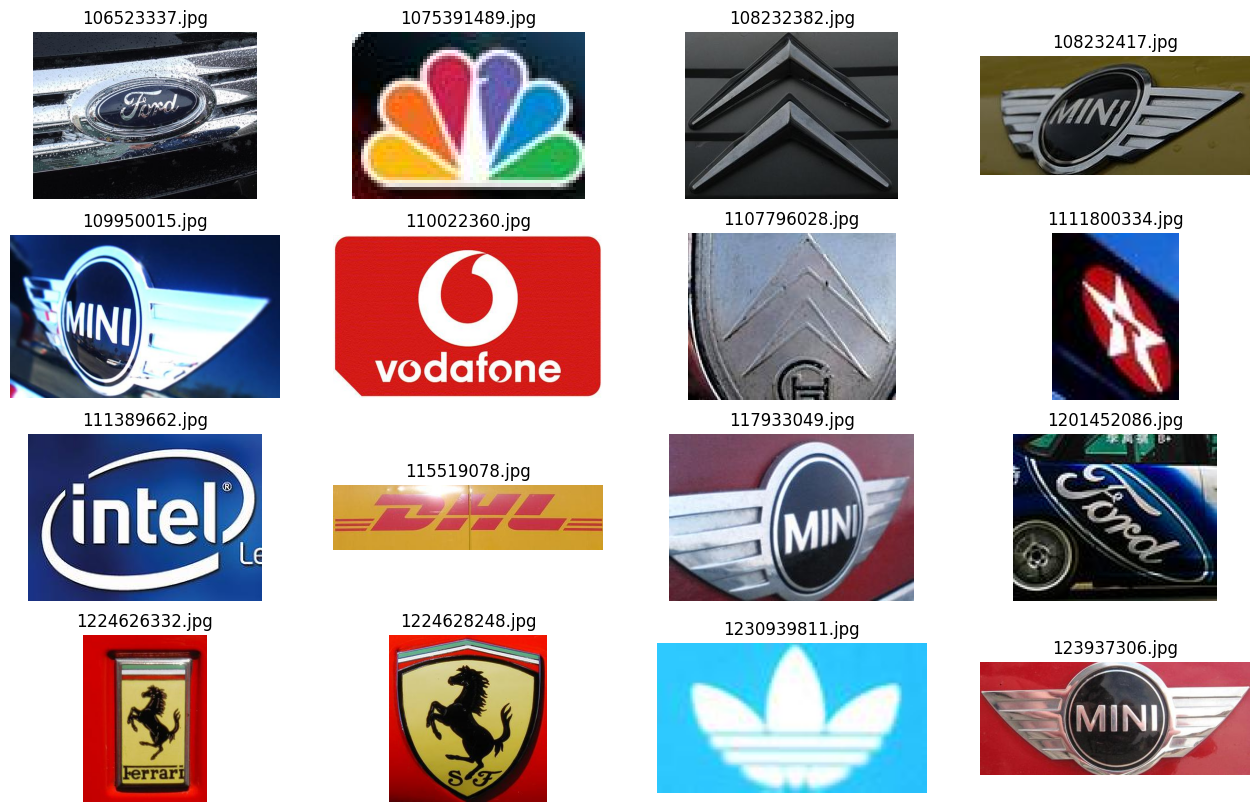

In [853]:
# print processed annotated logos 

plt.figure(figsize=(16, 10))
for idx in range(16):
    ax = plt.subplot(4, 4, idx + 1)
    plt.imshow(Image.open('cropped_images/'+ os.listdir('cropped_images')[idx]))
    plt.title(os.listdir('cropped_images')[idx])
    plt.axis("off")

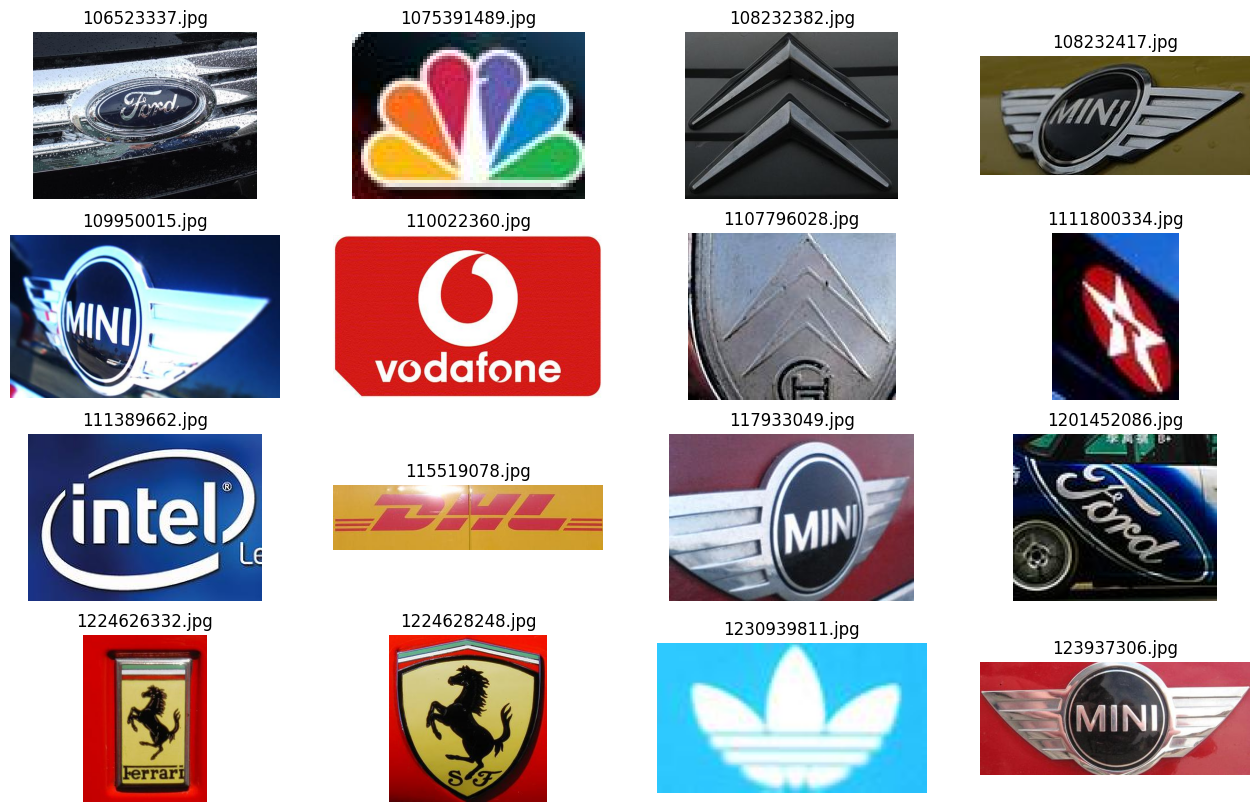

In [854]:
# print processed annotated logos 

plt.figure(figsize=(16, 10))
for idx in range(16):
    ax = plt.subplot(4, 4, idx + 1)
    plt.imshow(Image.open('cropped_images/'+ os.listdir('cropped_images')[idx]))
    plt.title(os.listdir('cropped_images')[idx])
    plt.axis("off")

#### Image augmentation ####

We create a function for augmenting images during the training process. This way we will have a more uniformal view of the image data.

In [855]:
train_augmentation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

### Creating dataset and splitting into training and validation sets ###


Next step is to split the data into training (80% of the full data) and testing data (20% of the full data).

In [858]:
# Split the augmented data into training and testing sets
train_images_augmented = train_images['file_name'].apply(lambda x: os.path.join('cropped_images', x)).tolist()
train_labels_augmented = train_images['label'].tolist()

train_images_aug, test_images_aug, train_labels_aug, test_labels_aug = train_test_split(
    train_images_augmented, train_labels_augmented, test_size=0.2, random_state=42)

In [861]:
train_ds = train_augmentation.flow_from_dataframe(
    dataframe=pd.DataFrame({"file_name": train_images_aug, "label": train_labels_aug}),
    directory="",
    x_col="file_name",
    y_col="label",
    target_size=(150, 150),
    batch_size=32,
    class_mode="categorical")

# Saving the brands and the indices of each one in a dictionary, to use later in the final matrix/graph
brands = train_ds.class_indices    

Found 3624 validated image filenames belonging to 27 classes.


c:\Users\ficti\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 4 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  warnings.warn(


### Building a Convolutional Neural Network (CNN) for image classification ###

When it comes to the model, the Xception model architecture was used, which weights pre-trained on the ImageNet dataset, not including the top layer of the model, as we will add our own classification layers later.

The shape of input images was set and the last 10 layers were frozen as a test, to prevent from losing their initial metrics from pre-training, updating the rest during training constantly. This did not provide a better results and only prolonged the running time, therefore was not used for the final model.

Additional layers were added:

-_GlobalAveragePooling2D_ applied to reduce the spatial dimensions of the feature maps to a vector, scoring a higher accuracy against other layers such as Flatten 

-A _Dense layer_ with 512 units and ReLU activation function was included, giving the highest standard accuracy

-A _Dropout layer_ with a dropout rate of 0.2 to prevent overfitting, after trying different rates, that most though, provided weird behaviour in the accuracy trend of the trained model or dropped the accuracy.

-Lastly, another _Dense layer_ with 27 units, equal to the number of classes and softmax activation function to produce the output probabilities for each class, were added.

In [874]:
# Adjusted the imports for the layers and model building
from tensorflow.keras.optimizers import Adam #, SGD, RMSprop, Adagrad, Adadelta, Adamax, Nadam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout #, Flatten
from tensorflow.keras.models import Model

base_model = Xception(weights="imagenet", include_top=False, input_shape=(150, 150, 3))

# Freeze the base model layers 
for layer in base_model.layers:
    layer.trainable = False

# One of the models we tested was to freeze only the last 10 layers, so that the other could change during the training adjusting
#for layer in base_model.layers[:-10]:
#    layer.trainable = True

# Add dense layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = Flatten()(x) #another model we tried was Flatten, but the model got slower and accuracy dropped
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Adding a dropout layer hightened the accuracy
predictions = Dense(27, activation='softmax')(x)

# Define and compile the Model 
model = Model(inputs=base_model.input, outputs=predictions)

# Tried optimisers: Adam, SGD, RMSprop, Adagrad, Adadelta, Adamax, Nadam and kept the one with the highest accuracy and lowest loss relatively to the rest
#model.compile(optimizer="Nadam", 
#model.compile(optimizer="Adamax", 
#model.compile(optimizer="Adadelta", 
#model.compile(optimizer="Adagrad", 
#model.compile(optimizer="SGD", 
#model.compile(optimizer="RMSprop", 

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In regards to the optimisers we tried, we tried 7 dfifferent ones, that produced the following accuracy and loss rates each (for the final test model):

**_Adam: Accuracy: 0.980154355016538  | Loss: 0.08131709970971307_**

_SGD: Accuracy: 0.9316427783902976  | Loss: 0.38381944693388076_

_RMSprop: Accuracy: 0.9768467475192943  | Loss: 0.08132553597478225_

_Adagrad: Accuracy: 0.8335170893054025  | Loss: 0.9756603339337424_

_Asadelta: Accuracy: 0.15986769570011025  | Loss: 2.9593978673120773_

_Adamax: Accuracy: 0.9768467475192943  | Loss: 0.12088652142784334_

_Nadam: Accuracy: 0.9724366041896362  | Loss: 0.10928058009832091_

### Plotting performance graphs ###

After completing the training with the model we have built, we plotted an accuracy trend, in order to visualise how it improves over time.

We tried various epoch numbers, with more epochs making little to no change in the accuracy and slowing the model, while less created some more intense ups and dowsn in the plot (so accuracy would drop abruptly in the middle epochs).

The final model was created by specifying the inputs (the input layer of the Xception model) and the outputs (the predictions from the classification layers).

Epoch 1/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 79s 605ms/step - accuracy: 0.5077 - loss: 1.8699
Epoch 2/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 68s 593ms/step - accuracy: 0.8674 - loss: 0.5306
Epoch 3/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 70s 607ms/step - accuracy: 0.9032 - loss: 0.3421
Epoch 4/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 70s 602ms/step - accuracy: 0.9153 - loss: 0.2938
Epoch 5/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 70s 603ms/step - accuracy: 0.9450 - loss: 0.1996
Epoch 6/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 74s 646ms/step - accuracy: 0.9508 - loss: 0.1983
Epoch 7/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 72s 620ms/step - accuracy: 0.9572 - loss: 0.1666
Epoch 8/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.9424 - loss: 0.1937
Epoch 9/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.9632 - loss: 0.1240
Epoch 10/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.9598 - loss: 0.1546
114/114 ━━━━━━━━━━━━━━━━━━━━ 82s 705ms/step - accuracy: 0.9908 - loss: 0.0541
Training Loss: 0.05836533382534981  |

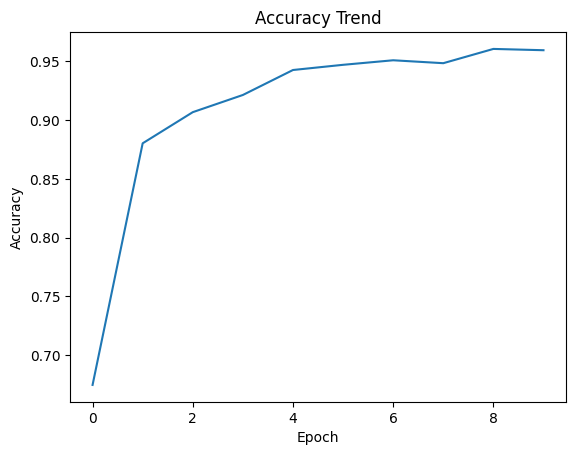

In [875]:
#import tensorflow as tf
# Plot model architecture
#tf.keras.utils.plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Training the model
history = model.fit(train_ds, epochs=10) # Here we could adjust the number of the epochs

# Evaluate the model on the training data
train_loss, train_accuracy = model.evaluate(train_ds)
print("Training Loss:", train_loss, " | Training Accuracy:", train_accuracy, )

# Plotting performance graphs
plt.plot(history.history["accuracy"])
plt.title("Accuracy Trend")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

### Predict images ###

Lastly, after training, we evaluated the model on the test set to assess its performance using accuracy. 

In [876]:
test_dgen = ImageDataGenerator(rescale=1./255)

test_ds = test_dgen.flow_from_dataframe(
    dataframe=pd.DataFrame({"file_name": test_images_aug, "label": test_labels_aug}),
    directory="",  
    x_col="file_name",
    y_col="label",
    target_size=(150, 150),
    batch_size=32,
    class_mode="categorical",
    shuffle=False)

predictions = model.predict(test_ds) 
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_ds.classes
class_labels = list(brands.keys())

Found 907 validated image filenames belonging to 27 classes.


c:\Users\ficti\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  warnings.warn(
c:\Users\ficti\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 611ms/step


Additionally, we generated a confusion matrix to gain insights into the model's classification behaviour. 

c:\Users\ficti\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Accuracy: 0.980154355016538  | Loss: 0.08131709970971307


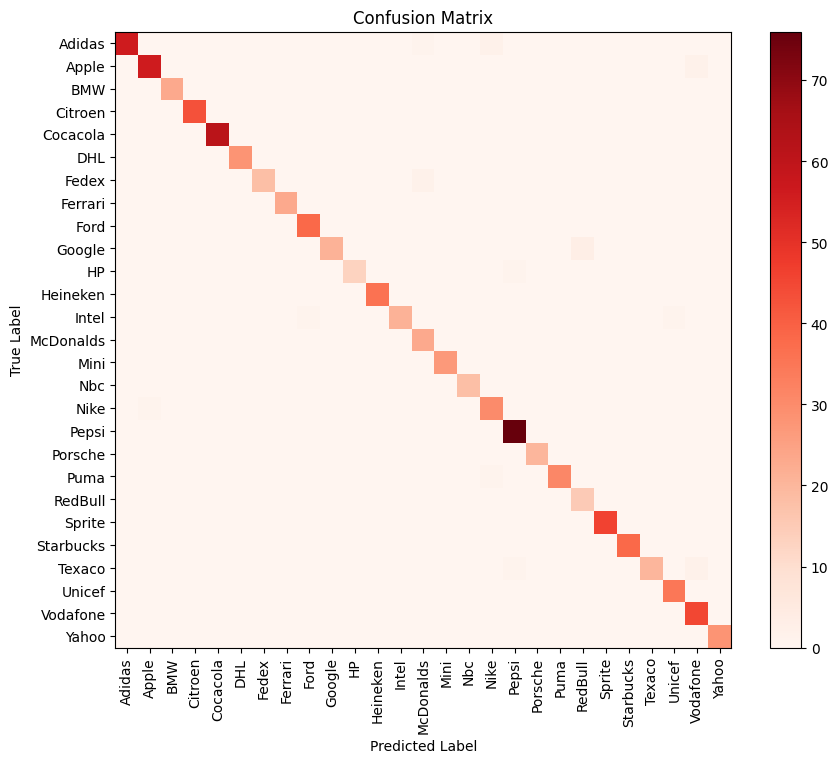

In [878]:
#Compute confusion matrix and accuracy
confusion_mtx = confusion_matrix(true_classes, predicted_classes)
accuracy = accuracy_score(true_classes, predicted_classes)
loss = log_loss(true_classes, predictions)
print("Accuracy:", accuracy, " | Loss:", loss)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(confusion_mtx, interpolation="nearest", cmap=plt.cm.Reds)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=90)
plt.yticks(tick_marks, class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Here we can see in a matrix how accurate the predictions were, using density as a way to represent it, with the aim to observe the distribution of predicted labels against true labels.

After the completion of the model, the test data were used to check its accuracy. Generally, the accuracy became higher with the addition of a dropout layer. Also, using different architectures, such as adding Dense layers and adjusting the unit number on each layer, we chose the ones that provided the best accuracy possible. The number of epochs was also adjusted to the one that provided the best results. This way, we chose the resulted model as the best and most accurate. The most research took place in regards to the optimiser, wwith which we experimented more and adjusted it accoridngly, after trying a couple of them.